In [30]:
SEED=42
# SEEDS = [42, 0, 2000,]
SEEDS = [42]
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, GroupKFold
# from lofo import LOFOImportance, Dataset, plot_importance
import lightgbm as lgb
from tqdm.notebook import tqdm
import itertools
%matplotlib inline
pd.set_option('max_columns', 300)
pd.set_option('max_rows', 300)

# Function to read our base train and test set
def read_train_test():
    train = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
    test = pd.read_csv('../input/optiver-realized-volatility-prediction/test.csv')
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_450', 'log_return2_realized_volatility_450', 
                'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_150', 'log_return2_realized_volatility_150', 
                'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_450', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_150']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', 'median']).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the time id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', 'median']).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')
    
    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

# Function to calculate the root mean squared percentage error
def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))

In [2]:
train, _ = read_train_test()
df_book = pd.read_csv('../input/processed-book-ffill/df_book.csv')
print(df_book.shape)
df_trade = pd.read_csv('../input/processed-book-ffill/df_trade.csv')
print(df_trade.shape)
train_ = df_book.merge(df_trade, on = ['row_id'], how = 'left')
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get group stats of time_id and stock_id
train = get_time_stock(train)
# train['logtarget'] = train['target'].apply(np.log)
train

Our training set has 428932 rows
(428932, 169)
(428913, 41)


,stock_id,time_id,target,row_id,wap1_sum,wap1_mean,wap1_std,wap1_median,wap2_sum,wap2_mean,wap2_std,wap2_median,log_return1_sum,log_return1_realized_volatility,log_return1_mean,log_return1_std,log_return1_median,log_return2_sum,log_return2_realized_volatility,log_return2_mean,log_return2_std,log_return2_median,wap_balance_sum,wap_balance_mean,wap_balance_std,wap_balance_median,price_spread_sum,price_spread_mean,price_spread_std,price_spread_median,bid_spread_sum,bid_spread_mean,bid_spread_std,bid_spread_median,ask_spread_sum,ask_spread_mean,ask_spread_std,ask_spread_median,total_volume_sum,total_volume_mean,total_volume_std,total_volume_median,volume_imbalance_sum,volume_imbalance_mean,volume_imbalance_std,volume_imbalance_median,wap1_sum_450,wap1_mean_450,wap1_std_450,wap1_median_450,wap2_sum_450,wap2_mean_450,wap2_std_450,wap2_median_450,log_return1_sum_450,log_return1_realized_volatility_450,log_return1_mean_450,log_return1_std_450,log_return1_median_450,log_return2_sum_450,log_return2_realized_volatility_450,log_return2_mean_450,log_return2_std_450,log_return2_median_450,wap_balance_sum_450,wap_balance_mean_450,wap_balance_std_450,wap_balance_median_450,price_spread_sum_450,price_spread_mean_450,price_spread_std_450,price_spread_median_450,bid_spread_sum_450,bid_spread_mean_450,bid_spread_std_450,bid_spread_median_450,ask_spread_sum_450,ask_spread_mean_450,ask_spread_std_450,ask_spread_median_450,total_volume_sum_450,total_volume_mean_450,total_volume_std_450,total_volume_median_450,volume_imbalance_sum_450,volume_imbalance_mean_450,volume_imbalance_std_450,volume_imbalance_median_450,wap1_sum_300,wap1_mean_300,wap1_std_300,wap1_median_300,wap2_sum_300,wap2_mean_300,wap2_std_300,wap2_median_300,log_return1_sum_300,log_return1_realized_volatility_300,log_return1_mean_300,log_return1_std_300,log_return1_median_300,log_return2_sum_300,log_return2_realized_volatility_300,log_return2_mean_300,log_return2_std_300,log_return2_median_300,wap_balance_sum_300,wap_balance_mean_300,wap_balance_std_300,wap_balance_median_300,price_spread_sum_300,price_spread_mean_300,price_spread_std_300,price_spread_median_300,bid_spread_sum_300,bid_spread_mean_300,bid_spread_std_300,bid_spread_median_300,ask_spread_sum_300,ask_spread_mean_300,ask_spread_std_300,ask_spread_median_300,total_volume_sum_300,total_volume_mean_300,total_volume_std_300,total_volume_median_300,volume_imbalance_sum_300,volume_imbalance_mean_300,volume_imbalance_std_300,volume_imbalance_median_300,wap1_sum_150,wap1_mean_150,wap1_std_150,wap1_median_150,wap2_sum_150,wap2_mean_150,wap2_std_150,wap2_median_150,log_return1_sum_150,log_return1_realized_volatility_150,log_return1_mean_150,log_return1_std_150,log_return1_median_150,log_return2_sum_150,log_return2_realized_volatility_150,log_return2_mean_150,log_return2_std_150,log_return2_median_150,wap_balance_sum_150,wap_balance_mean_150,...,trade_log_return_realized_volatility_450,trade_seconds_in_bucket_count_unique_450,trade_size_mean_450,trade_size_median_450,trade_size_std_450,trade_size_sum_450,trade_order_count_mean_450,trade_order_count_median_450,trade_order_count_std_450,trade_order_count_sum_450,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_mean_300,trade_size_median_300,trade_size_std_300,trade_size_sum_300,trade_order_count_mean_300,trade_order_count_median_300,trade_order_count_std_300,trade_order_count_sum_300,trade_log_return_realized_volatility_150,trade_seconds_in_bucket_count_unique_150,trade_size_mean_150,trade_size_median_150,trade_size_std_150,trade_size_sum_150,trade_order_count_mean_150,trade_order_count_median_150,trade_order_count_std_150,trade_order_count_sum_150,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return1_realized_volatility_median_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,lo

# Get base score

In [39]:
params = {
    'random_state': SEED,
    'objective': 'rmse',  
    'boosting_type': 'gbdt',
#     'num_leaves': 100,
#     'learning_rate': 0.1,
#     'colsample_bytree': 0.8,
#     'subsample': 0.8,
#     'n_estimators': 1000,
    'min_child_samples': int(0.01*train.shape[0])
}
feature_cols = [c for c in train.columns if c not in ['row_id', 'target', 'time_id', 'stock_id', 'target']]
wap1_cols = [c for c in feature_cols if c.split('_')[0]=='wap1']
feature_cols = [c for c in feature_cols if c not in wap1_cols]
print(f"#feature: {len(feature_cols)}")
kfold = GroupKFold(n_splits=5)

In [40]:
base_cv_score = np.zeros(5*len(SEEDS), dtype=np.float32)
for j, s in enumerate(SEEDS):
    train_shuffled = train.sample(frac=1, random_state=s).reset_index(drop=True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_shuffled, groups=train_shuffled.time_id)):
        print(f"shuffled with seed {s} fold {fold}")
        x_train, x_val = train_shuffled.loc[trn_ind, feature_cols], train_shuffled.loc[val_ind, feature_cols]
        y_train, y_val = train_shuffled.loc[trn_ind, 'target'], train_shuffled.loc[val_ind, 'target']

        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)

        # Fit with sklearn API
        model = lgb.LGBMRegressor(**params)
        model.fit(x_train, 
                  y_train, 
                  sample_weight=train_weights,
                  eval_set=[(x_val, y_val)],
                  eval_sample_weight=[val_weights],
                  eval_metric='rmse',
                  early_stopping_rounds=100,
                  verbose=False)
        seed_fold_score = rmspe(y_val, model.predict(x_val))
        base_cv_score[5*j+fold] = seed_fold_score
        print(f"rmspe {seed_fold_score}")

shuffled with seed 42 fold 0
rmspe 0.2302428235591513
shuffled with seed 42 fold 1
rmspe 0.23961212999633766
shuffled with seed 42 fold 2
rmspe 0.2230520987807969
shuffled with seed 42 fold 3
rmspe 0.22146007259843267
shuffled with seed 42 fold 4
rmspe 0.21860704800882494


# LOFO

In [41]:
feature_groups = {
#     'wap1': [c for c in feature_cols if c.split('_')[0]=='wap1'], # removed
    
    'wap2': [c for c in feature_cols if c.split('_')[0]=='wap2'],
    'log_return1': [c for c in feature_cols if c.split('_')[0:2]==['log', 'return1'] and c.split('_')[-1] not in ['time', 'stock']],
    'log_return2': [c for c in feature_cols if c.split('_')[0:2]==['log', 'return2'] and c.split('_')[-1] not in ['time', 'stock']],
    'wap_balance': [c for c in feature_cols if c.split('_')[0:2]==['wap', 'balance']],
    'price_spread': [c for c in feature_cols if c.split('_')[0:2]==['price', 'spread']],
    'bid_spread': [c for c in feature_cols if c.split('_')[0:2]==['bid', 'spread']],
    'ask_spread': [c for c in feature_cols if c.split('_')[0:2]==['ask', 'spread']],
    'total_volume': [c for c in feature_cols if c.split('_')[0:2]==['total', 'volume']],
    'volume_imbalance': [c for c in feature_cols if c.split('_')[0:2]==['volume', 'imbalance']],
    'trade_log_return': [c for c in feature_cols if c.split('_')[0:3]==['trade', 'log', 'return'] and c.split('_')[-1] not in ['time', 'stock']],
    'trade_seconds_in_bucket': [c for c in feature_cols if c.split('_')[0:4]==['trade', 'seconds', 'in', 'bucket']],    
    'trade_size': [c for c in feature_cols if c.split('_')[0:2]==['trade', 'size']],
    'trade_order_count': [c for c in feature_cols if c.split('_')[0:3]==['trade', 'order', 'count']],
    'timeagg': [c for c in feature_cols if c.split('_')[-1]=='time'],
    'stockagg': [c for c in feature_cols if c.split('_')[-1]=='stock'],
    
#     '150': [c for c in feature_cols if '150' in c],
#     '300': [c for c in feature_cols if '300' in c],
#     '450': [c for c in feature_cols if '450' in c],

}
grouped_features = list(itertools.chain.from_iterable(feature_groups.values()))
len(grouped_features), len(set(grouped_features))

(312, 312)

In [42]:
not_grouped_features = {}
for fea in feature_cols:
    if fea not in set(grouped_features):
        not_grouped_features[fea] = [fea]
# feature_groups = {**feature_groups, **not_grouped_features}
len(not_grouped_features)

0

In [43]:
lofo_cv_scores = np.zeros((len(feature_groups), 5*len(SEEDS)), dtype=np.float32)
for i, group_to_drop in enumerate(tqdm(feature_groups.keys())):
    lofo_cols = [c for c in feature_cols if c not in feature_groups[group_to_drop]]
    for j, s in enumerate(SEEDS):
        train_shuffled = train.sample(frac=1, random_state=s).reset_index(drop=True)
        for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_shuffled, groups=train_shuffled.time_id)):
            x_train, x_val = train_shuffled.loc[trn_ind, lofo_cols], train_shuffled.loc[val_ind, lofo_cols]
            y_train, y_val = train_shuffled.loc[trn_ind, 'target'], train_shuffled.loc[val_ind, 'target']

            # Root mean squared percentage error weights
            train_weights = 1 / np.square(y_train)
            val_weights = 1 / np.square(y_val)

            # Fit with sklearn API
            model = lgb.LGBMRegressor(**params)
            model.fit(x_train, 
                      y_train, 
                      sample_weight=train_weights,
                      eval_set=[(x_val, y_val)],
                      eval_sample_weight=[val_weights],
                      eval_metric='rmse',
                      early_stopping_rounds=100,
                      verbose=False)
            lofo_cv_scores[i, 5*j+fold] = rmspe(y_val, model.predict(x_val))

  0%|          | 0/15 [00:00<?, ?it/s]

In [44]:
# https://github.com/aerdem4/lofo-importance/blob/efbb00bf47ae329aa1fd98ec8a46aaca6841b21a/lofo/utils.py#L5
def lofo_to_df(lofo_scores, feature_list):
    importance_df = pd.DataFrame()
    importance_df["feature"] = feature_list
    importance_df["importance_mean"] = lofo_scores.mean(axis=1)
    importance_df["importance_std"] = lofo_scores.std(axis=1)

    for val_score in range(lofo_scores.shape[1]):
        importance_df["val_imp_{}".format(val_score)] = lofo_scores[:, val_score]

    return importance_df.sort_values("importance_mean", ascending=False)

# https://github.com/aerdem4/lofo-importance/blob/master/lofo/plotting.py
def plot_importance(importance_df, figsize=(8, 8), kind="default"):
    """Plot feature importance
    Parameters
    ----------
    importance_df : pandas dataframe
        Output dataframe from LOFO/FLOFO get_importance
    kind : string
        plot type can be default or box
    figsize : tuple
    """
    importance_df = importance_df.copy()
    importance_df["color"] = (importance_df["importance_mean"] > 0).map({True: 'g', False: 'r'})
    importance_df.sort_values("importance_mean", inplace=True)

    available_kinds = {"default", "box"}
    if kind not in available_kinds:
        warnings.warn("{kind} not in {ak}. Setting to default".format(kind=kind, ak=available_kinds))

    if kind == "default":
        importance_df.plot(x="feature", y="importance_mean", xerr="importance_std",
                           kind='barh', color=importance_df["color"], figsize=figsize)
    elif kind == "box":
        lofo_score_cols = [col for col in importance_df.columns if col.startswith("val_imp")]
        features = importance_df["feature"].values.tolist()
        importance_df.set_index("feature")[lofo_score_cols].T.boxplot(column=features, vert=False, figsize=figsize)

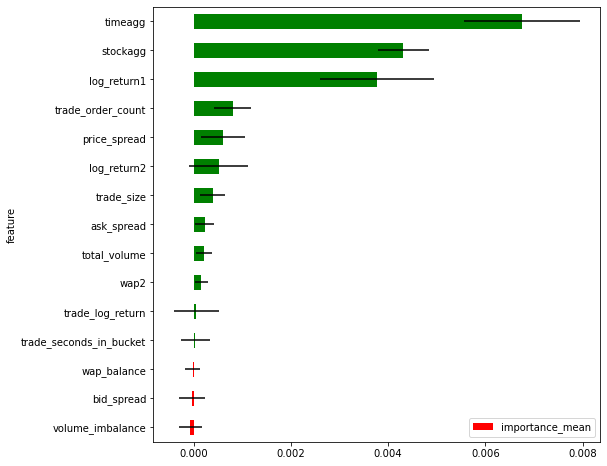

In [45]:
lofo_cv_scores_normalized = np.array([lofo_cv_score-base_cv_score for lofo_cv_score in lofo_cv_scores])
lofo_df = lofo_to_df(lofo_cv_scores_normalized, list(feature_groups.keys()))
lofo_df.to_csv("lofo_df.csv", index=False)
plot_importance(lofo_df)

In [47]:
lofo_df.importance_mean.min()

-7.556677155662328e-05

In [54]:
lofo_df.iloc[-1].feature

'volume_imbalance'

In [50]:
lofo_df

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3,val_imp_4
13,timeagg,0.006748,0.001191,0.007735,0.005515,0.005086,0.007796,0.007607
14,stockagg,0.004312,0.000532,0.004405,0.003826,0.003638,0.004576,0.005115
1,log_return1,0.003769,0.001169,0.002249,0.004828,0.002490,0.004288,0.004990
12,trade_order_count,0.000798,0.000380,0.001152,0.000833,0.000471,0.001259,0.000273
4,price_spread,0.000599,0.000455,0.000951,0.000315,0.000244,0.001320,0.000167
2,log_return2,0.000508,0.000612,0.001421,0.000100,0.000932,-0.000317,0.000402
11,trade_size,0.000386,0.000261,0.000314,0.000542,0.000418,0.000719,-0.000061
6,ask_spread,0.000222,0.000192,0.000434,-0.000102,0.000119,0.000319,0.000342
7,total_volume,0.000206,0.000160,-0.000071,0.000401,0.000219,0.000167,0.000315
0,wap2,0.000154,0.000136,0.000009,0.000160,0.000409,0.000109,0.000085
